In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path

from jigsaw.settings import DATA_DIR, MODEL_DIR
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import torch
from torch.utils.data import DataLoader



In [2]:
from jigsaw.settings import TRAIN_CSV

df = pd.read_csv(TRAIN_CSV)
df.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


In [3]:
from tqdm.notebook import tqdm
from jigsaw.settings import TRAIN_CSV

def build_samples(df):

    samples = []

    for row in tqdm(df.itertuples()):
        row_id = row.row_id
        rule = row.rule
        subreddit = row.subreddit
        base_label = int(row.rule_violation)

        for comment_type in [
            "body",
            "positive_example_1",
            "positive_example_2",
            "negative_example_1",
            "negative_example_2",
        ]:
            # Correct label assignment by source field
            if comment_type.startswith("positive"):
                label = 1
            elif comment_type.startswith("negative"):
                label = 0
            else:
                label = base_label

            samples.append(
                {
                    "row_id": row_id,
                    "comment": row.__getattribute__(comment_type),
                    "subreddit": subreddit,
                    "rule": rule,
                    "rule_violation": label,
                }
            )

    new_df = pd.DataFrame(samples)
    new_df.drop_duplicates(subset=["comment"], inplace=True)
    return new_df

In [4]:
rules = {i: rule for i, rule in enumerate(sorted(df["rule"].unique()))}
idx_by_rule = {rule: idx for idx, rule in rules.items()}
print(rules)

{0: 'No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.', 1: 'No legal advice: Do not offer or request legal advice.'}


In [5]:
spam_df = df[df["rule"] == rules[0]]
legal_df = df[df["rule"] == rules[1]]

In [6]:
spam_df = build_samples(spam_df)
len(spam_df)

0it [00:00, ?it/s]

862

In [7]:
legal_df = build_samples(legal_df)
len(legal_df)


0it [00:00, ?it/s]

1013

In [8]:
legal_df.head()

,row_id,comment,subreddit,rule,rule_violation
0,2,Lol. Try appealing the ban and say you won't d...,pcmasterrace,No legal advice: Do not offer or request legal...,1
1,2,Don't break up with him or call the cops. If ...,pcmasterrace,No legal advice: Do not offer or request legal...,1
2,2,It'll be dismissed: https://en.wikipedia.org/w...,pcmasterrace,No legal advice: Do not offer or request legal...,1
3,2,Where is there a site that still works where y...,pcmasterrace,No legal advice: Do not offer or request legal...,0
4,2,Because this statement of his is true. It isn'...,pcmasterrace,No legal advice: Do not offer or request legal...,0


In [9]:
import os
import random

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
import re

# Pre-compiled regex patterns
URL_PATTERN = re.compile(r'https?://[^\s/$.?#].[^\s]*')
DOMAIN_PATTERN = re.compile(r"(?:https?://)?([a-z0-9\-\.]+)\.[a-z]{2,}")
CLEAN_PATH_PART_PATTERN = re.compile(r"\.(html?|php|asp|jsp)$|#.*|\?.*")


def url_to_semantics(text: str) -> str:
    """
    Extracts semantic keywords from URLs found in a given text.
    Returns a formatted string containing semantic features.
    """
    if not isinstance(text, str):
        return ""

    urls = URL_PATTERN.findall(text)
    if not urls:
        return "" 

    all_semantics = []
    seen_semantics = set()

    for url in urls:
        url_lower = url.lower()

        # Extract domain parts
        domain_match = DOMAIN_PATTERN.search(url_lower)
        if domain_match:
            full_domain = domain_match.group(1)
            for part in full_domain.split('.'):
                if part and part not in seen_semantics and len(part) > 3:
                    all_semantics.append(f"domain:{part}")
                    seen_semantics.add(part)

        # Extract path parts
        path = re.sub(r"^(?:https?://)?[a-z0-9\.-]+\.[a-z]{2,}/?", "", url_lower)
        path_parts = [p for p in re.split(r'[/_.-]+', path) if p and p.isalnum()]
        
        for part in path_parts:
            part_clean = CLEAN_PATH_PART_PATTERN.sub("", part)
            if part_clean and part_clean not in seen_semantics and len(part_clean) > 3:
                all_semantics.append(f"path:{part_clean}")
                seen_semantics.add(part_clean)

    return f"\nURL Keywords: {' '.join(all_semantics)}" if all_semantics else ""

In [11]:
from torch.optim import AdamW

class CFG:
    model_name_or_path = "microsoft/deberta-v3-small"
    output_dir = MODEL_DIR / "deberta-v3-small"
  
    EPOCHS = 2
    LEARNING_RATE = 1e-5  
    
    MAX_LENGTH = 512
    BATCH_SIZE = 8

class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def add_url_semantics_column(df):
    return df['comment'].apply(lambda x: x + url_to_semantics(x))

def build_input_text(df):
    df['body_with_url'] = add_url_semantics_column(df)
    return df['rule'] + "[SEP]" + df["subreddit"] + "[SEP]" + df['body_with_url']

def prepare_dataset(df, tokenizer, max_length, is_train=True):
    encodings = tokenizer(
        df['input_text'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length
    )
    if is_train:
        labels = df['rule_violation'].tolist()
        return JigsawDataset(encodings, labels)
    else:
        return JigsawDataset(encodings)

def train(train_df, seed=4):
    seed_everything(seed)
    print(f"\n🔸 Loading and preparing training data with seed={seed} ...")
    print(f"Training dataset size: {len(train_df)}")

    
    train_df['input_text'] = build_input_text(train_df)

    tokenizer = AutoTokenizer.from_pretrained(CFG.model_name_or_path)
    train_dataset = prepare_dataset(train_df, tokenizer, CFG.MAX_LENGTH, is_train=True)

    model = AutoModelForSequenceClassification.from_pretrained(CFG.model_name_or_path, num_labels=2)

    # Initialize classifier weights
    # torch.nn.init.normal_(model.classifier.weight, mean=0.0, std=0.02)
    # torch.nn.init.constant_(model.classifier.bias, 0.0)
    
    # # Create optimizer with differential learning rates
    # classifier_params = []
    # other_params = []
    
    # for name, param in model.named_parameters():
    #     if 'classifier' in name:
    #         classifier_params.append(param)
    #     else:
    #         other_params.append(param)
    
    # optimizer_grouped_parameters = [
    #     {'params': other_params, 'lr': 5e-6},
    #     {'params': classifier_params, 'lr': CFG.LEARNING_RATE}
    # ]
    
    
    # optimizer = AdamW(optimizer_grouped_parameters)
    
    training_args = TrainingArguments(
        output_dir=CFG.output_dir,
        num_train_epochs=CFG.EPOCHS,
        learning_rate=CFG.LEARNING_RATE,
        per_device_train_batch_size=CFG.BATCH_SIZE,
        warmup_ratio=0.15,
        weight_decay=0.01,
        report_to="wandb",
        save_strategy="no",
        lr_scheduler_type="cosine",
        max_grad_norm=1.0,
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        # optimizers=(optimizer, None),
    )

    print("🚀 Starting training...")
    trainer.train()
    print("✅ Training complete.")

    return trainer, tokenizer

In [12]:
def create_folds(df, n_folds=5, seed=42):
    """
    Randomly split a dataframe into n folds.
    
    Args:
        df: DataFrame to split
        n_folds: Number of folds to create
        seed: Random seed for reproducibility
    
    Returns:
        DataFrame with added 'fold' column
    """
    df = df.copy()
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    df['fold'] = df.index % n_folds
    return df


spam_df = create_folds(spam_df, n_folds=5, seed=42)
spam_df.head()


,row_id,comment,subreddit,rule,rule_violation,fold
0,978,we do have a shop check it out here https://ww...,pokemon,"No Advertising: Spam, referral links, unsolici...",1,0
1,585,Same shit happened to me man. EXACT same thin...,AskReddit,"No Advertising: Spam, referral links, unsolici...",0,1
2,59,If you invest your money in Queen Rubie's for-...,personalfinance,"No Advertising: Spam, referral links, unsolici...",1,2
3,102,I found a web site that says to share a link t...,anime,"No Advertising: Spam, referral links, unsolici...",1,3
4,242,This app tracks medals of all countries\nhttps...,worldnews,"No Advertising: Spam, referral links, unsolici...",0,4


In [13]:
eval_spam_df = spam_df[spam_df['fold'] == 0]
train_spam_df = spam_df[spam_df['fold'] != 0]

trainer, tokenizer = train(train_spam_df)


🔸 Loading and preparing training data with seed=4 ...
Training dataset size: 689


/tmp/ipykernel_278832/442685796.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body_with_url'] = add_url_semantics_column(df)
/tmp/ipykernel_278832/442685796.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['input_text'] = build_input_text(train_df)
/home/felix/repos/jigsaw/.venv/lib/python3.13/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not impleme

🚀 Starting training...


wandb: Currently logged in as: felix-newman (project-vesuvius) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.733800
20,0.672200
30,0.716500
40,0.692500
50,0.655200
60,0.691400
70,0.734600
80,0.688000
90,0.688400
100,0.678600


✅ Training complete.


In [14]:
def predict(trainer, tokenizer, seed, eval_df):
    eval_df['input_text'] = build_input_text(eval_df)
    
    test_dataset = prepare_dataset(eval_df, tokenizer, CFG.MAX_LENGTH, is_train=False)

    print("🔮 Running prediction...")
    predictions = trainer.predict(test_dataset)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

    eval_df['rule_violation_pred'] = probs
    return eval_df

eval_spam_df = predict(trainer, tokenizer, 42, eval_spam_df)
eval_spam_df.head()






🔮 Running prediction...


/tmp/ipykernel_278832/442685796.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body_with_url'] = add_url_semantics_column(df)
/tmp/ipykernel_278832/2635419916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['input_text'] = build_input_text(eval_df)


/tmp/ipykernel_278832/2635419916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['rule_violation_pred'] = probs


,row_id,comment,subreddit,rule,rule_violation,fold,body_with_url,input_text,rule_violation_pred
0,978,we do have a shop check it out here https://ww...,pokemon,"No Advertising: Spam, referral links, unsolici...",1,0,we do have a shop check it out here https://ww...,"No Advertising: Spam, referral links, unsolici...",0.453401
5,1685,[Sassy t-shirts need constant attention to sur...,pics,"No Advertising: Spam, referral links, unsolici...",0,0,[Sassy t-shirts need constant attention to sur...,"No Advertising: Spam, referral links, unsolici...",0.418744
10,525,Phentermine is a prescription only drug prescr...,AskReddit,"No Advertising: Spam, referral links, unsolici...",1,0,Phentermine is a prescription only drug prescr...,"No Advertising: Spam, referral links, unsolici...",0.479585
15,99,Remember to use a [recruit a friend link](http...,AskReddit,"No Advertising: Spam, referral links, unsolici...",0,0,Remember to use a [recruit a friend link](http...,"No Advertising: Spam, referral links, unsolici...",0.462684
20,256,"Check out our YouTube Channel, we’re new to Yo...",OldSchoolCool,"No Advertising: Spam, referral links, unsolici...",0,0,"Check out our YouTube Channel, we’re new to Yo...","No Advertising: Spam, referral links, unsolici...",0.426527


ROC AUC Score: 0.8129 - Fold 0 - Rule No Advertising: Spam


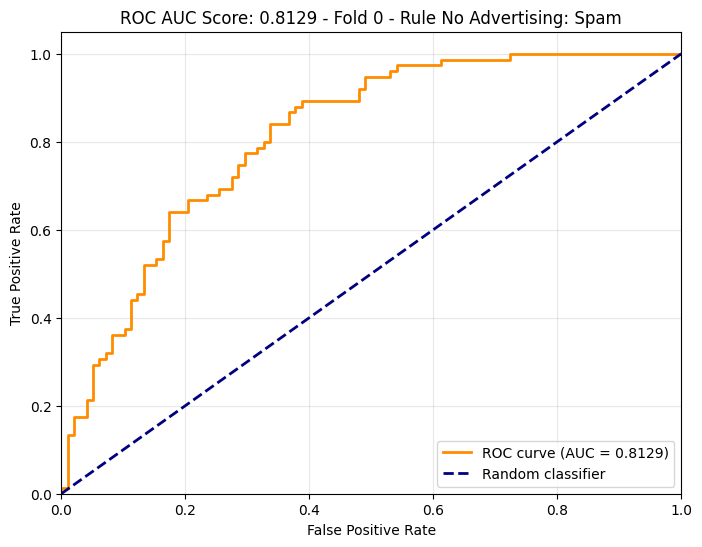

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(eval_df):
    roc_auc = roc_auc_score(eval_df['rule_violation'], eval_df['rule_violation_pred'])
    print(f"ROC AUC Score: {roc_auc:.4f} - Fold {eval_df['fold'].iloc[0]} - Rule {eval_df['rule'].iloc[0][:20]}")

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(eval_df['rule_violation'], eval_df['rule_violation_pred'])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC AUC Score: {roc_auc:.4f} - Fold {eval_df['fold'].iloc[0]} - Rule {eval_df['rule'].iloc[0][:20]}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curve(eval_spam_df)


NameError: name 'model' is not defined

In [ ]:
trainer.model

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo